# Error mitigation

Quantum Computing noise mitigation and error correction as well as correct device mapping can be a highly technical and challenging topic. These code examples are just some simple approaches to error mitigation readers can follow in order to start exploring and dealing with the examples shown in the book against real devices.

In order to access real devices, an IBM Quantum Experience is required. Create it in [https://quantum-computing.ibm.com/](https://quantum-computing.ibm.com/) if you do not have one yet. API token will be required below in order to follow the example using real devices.

As in previous examples a local python environment can be created and dependencies installed with following commands:
```
$ python -m venv <env-name>
(env-name)$ pip install -r requirements.txt 
```
Following cells will take the reader into common error mitigation (bitflip, phaseflip and readout errors) but in order to get deeper understanding on the techniques that could be used, please, follow the examples in:

* Qiskit tutorials: https://qiskit.org/ecosystem/experiments/manuals/measurement/readout_mitigation.html
* Mitiq package : https://mitiq.readthedocs.io/en/stable/examples/examples.html

Let's create the most simple circuit we could think of, a simple quantum circuit that reads the basic state most devices get started with: $|00\rangle$

In [1]:
from qiskit import QuantumCircuit

# |00>
qc = QuantumCircuit(2,2)
qc.measure([0, 1], [0, 1])

qc.draw()

┌─┐   
q_0: ┤M├───
     └╥┘┌─┐
q_1: ─╫─┤M├
      ║ └╥┘
c: 2/═╩══╩═
      0  1

And we will replicate the noise model of one of IBM's available devices. For that remember you might need to first save your current account by invoking
```
from qiskit import IBMQ

IBMQ.save_account("<IBM experience token>")
```

After this one can simple load the local account and select a backend to run circuits on.
```
IBMQ.load_account() # Load account from disk
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_lima')
```

Backends can be also locally emulated by loading the noise model of a given backend into a local simulator:
```
from qiskit.providers.aer import AerSimulator

simulator = AerSimulator()
emulator = AerSimulator.from_backend(backend)
```

For the sake fo simplicity, Qiskit already provides a set of _fake_ backends which already provide an emulator for the backend of the same name.

In [2]:
from qiskit.providers.aer import AerSimulator
from qiskit.providers.fake_provider import FakeLima

# Perfect simulator
simulator = AerSimulator()

# Emulator for the ibmq_lima device
emulator = FakeLima()

Let's now run the circuit preparend the state $|00\rangle$ using the simulator. If we try to read the state for a number of times, they should all plot the $00$ bitstring as the only possible outcome.

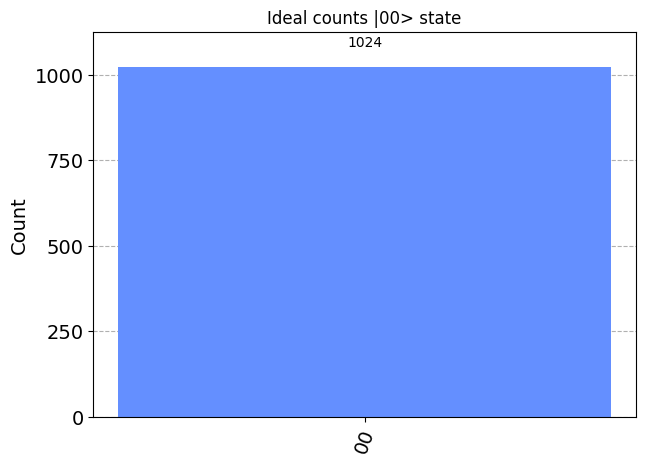

In [3]:
from qiskit.tools.visualization import plot_histogram

# Execute and get counts
result = simulator.run(qc).result()
counts = result.get_counts(0)
plot_histogram(counts, title='Ideal counts |00> state')

Above figure shows the outcome for 1024 iterations on the same state preparation (circuit runs), obtaining the expected state 100% of the times (1024 out of 1024).

But when using the emulator, some errors might occur that show theoretically imposible bitstrings to be read ($01$ and $10$ in the case below). Therefore, even though the circuit we run should prepare the $|00\rangle$, from the bitstrings at readout it looks like a mixture including $|01\rangle$ and $|10\rangle$ state is obtained. It is hard to set from the discrete counts devices provide what is the actual state being prepared, but indeed, something unexpected is happening considering our theoretical result.

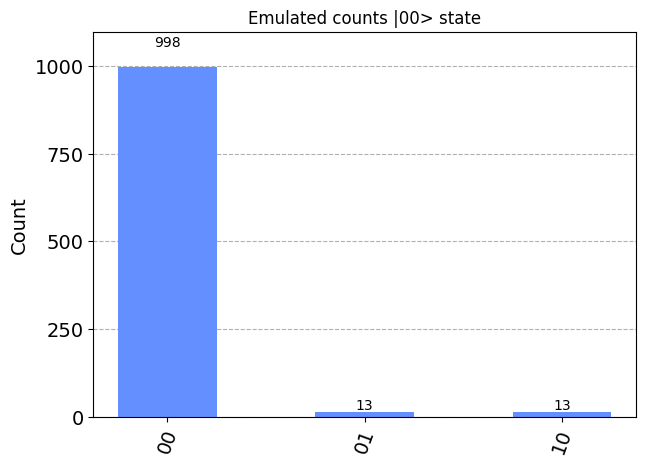

In [4]:
# Execute and get counts
result = emulator.run(qc).result()
counts = result.get_counts(0)
plot_histogram(counts, title='Emulated counts |00> state')

Given that in this case the circuit performs nothing but qubit measurements, most likely our error is given by the measuring process (we fail when measuring). This is often a systematic error in the device we can chacaterize and mitigate, translating what it would have been for a perfect readout.

Qiskit already provides tools to create the circuits needed to get the calibration matrix, the matrix that allows to transalate between obtained measurements to corrected one (when measuring without those errors). This action tries to compensate device systematic errors.

In [5]:
from qiskit_experiments.library import CorrelatedReadoutError

qubits = [0,1]
num_qubits = len(qubits)
exp = CorrelatedReadoutError(qubits)
for c in exp.circuits():
    print(c)

         ░ ┌─┐   
   q_0: ─░─┤M├───
         ░ └╥┘┌─┐
   q_1: ─░──╫─┤M├
         ░  ║ └╥┘
meas: 2/════╩══╩═
            0  1 
        ┌───┐ ░ ┌─┐   
   q_0: ┤ X ├─░─┤M├───
        └───┘ ░ └╥┘┌─┐
   q_1: ──────░──╫─┤M├
              ░  ║ └╥┘
meas: 2/═════════╩══╩═
                 0  1 
              ░ ┌─┐   
   q_0: ──────░─┤M├───
        ┌───┐ ░ └╥┘┌─┐
   q_1: ┤ X ├─░──╫─┤M├
        └───┘ ░  ║ └╥┘
meas: 2/═════════╩══╩═
                 0  1 
        ┌───┐ ░ ┌─┐   
   q_0: ┤ X ├─░─┤M├───
        ├───┤ ░ └╥┘┌─┐
   q_1: ┤ X ├─░──╫─┤M├
        └───┘ ░  ║ └╥┘
meas: 2/═════════╩══╩═
                 0  1 


Adding a job from a backend (aer_simulator) that is different than the current backend (fake_lima). The new backend will be used, but service is not changed if one already exists.


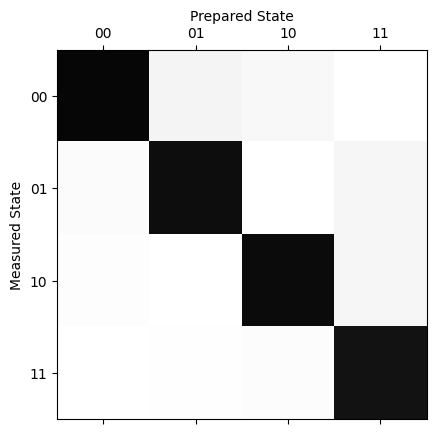

In [6]:
result = exp.run(emulator)
mitigator = result.analysis_results(0).value
result.figure(0)

Above matrix presents the translation need to be done when reading two-qubit states using the _fake_ Lima device. Some light grey areas above and below the diagonal characterizes how some state transitions happen between prepared and measured states.

By taking previously obtained counts, the number of times each state was read from the device, we can obtain the unmitigated probabilities for each of them. The actual probabilities we have obtained for each state to be read upon the $|00\rangle$ state preparation.

In [8]:
unmitigated_probs = {label: count / 1024 for label, count in counts.items()}
unmitigated_probs

{'01': 0.0126953125, '10': 0.0126953125, '00': 0.974609375}

And then add the action of the matrix that will transfer some of those counts according to the proabbilities shown by above calibration matrix.

In [9]:
mitigated_quasi_probs = mitigator.quasi_probabilities(counts)
mitigated_stddev = mitigated_quasi_probs._stddev_upper_bound
mitigated_probs = (mitigated_quasi_probs.nearest_probability_distribution().binary_probabilities())
mitigated_probs

{'10': 0.000975366012702364, '00': 0.9990246339872977}

Odd number indeed as it points out still we would observe '10' string in some cases, but we will be dealing with this kind of numerical inprecisions when dealing with numerical resolutions at the scale that Python allows.

Visually we can represent what the effect is showing in dark pink the readout states for the 1024 shots we performed using the _fake_ Lima device and how the compensated probabilities take those to the single value expected from the measurement of $|00\rangle$ state (hence $0$).

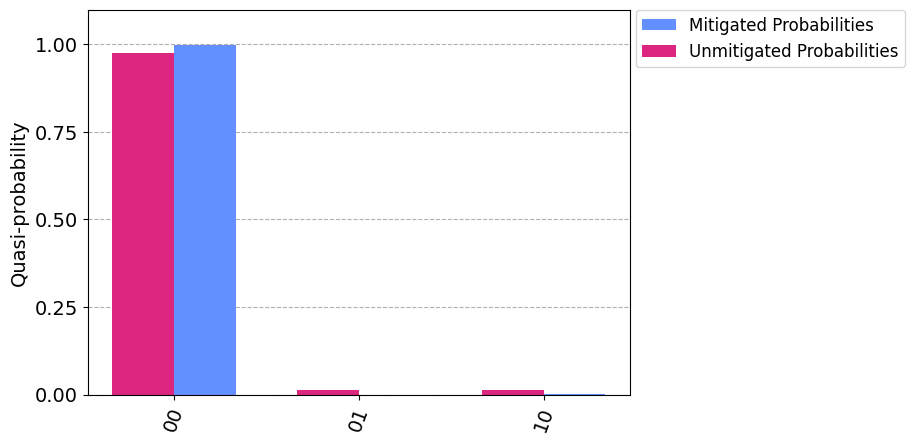

In [10]:
legend = ['Mitigated Probabilities', 'Unmitigated Probabilities']
plot_histogram([mitigated_probs, unmitigated_probs], legend=legend, sort="value_desc", bar_labels=False)

Using real devices will introduce this imperfections, noise, that will not be fully mitigated or will limit the accuracy one can reach in certain scenarios. In our case, imagging that low value derivative pricing can be affected by this small fluctuations we could face when using real devices.

Therefore, it becomes relevant if our strategy alignes with those providers aiming for large scale devices were we will be that will allwo our derivatice pricing to remain withihn our allowed accuracy regime (i.e. IonQ or Quantinuum).